# Assignment 3
## Sensitivity Analysis with total-effect Sobol-indices
### Group D
### Autors: Aleksandar Ivanov, Florian Bernhard, Simon Schroeppel

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Default values of model parameters:

In [2]:
BETA = 14/9
ALPHA = 7/3
GAMMA = 7/9
I_0 = 1000
N = 80000000
WEEKS = 60
SAMPLES = 1000

BETA_LOW = 1
BETA_HIGH = 3
ALPHA_LOW = 0.5
ALPHA_HIGH = 3.5
GAMMA_LOW = 0.5
GAMMA_HIGH = 1
I_0_LOW = 500
I_0_HIGH = 2500
PARAM_LOWS = [BETA_LOW, ALPHA_LOW, GAMMA_LOW, I_0_LOW]
PARAM_HIGHS = [BETA_HIGH, ALPHA_HIGH, GAMMA_HIGH, I_0_HIGH]
DIMENSIONS = len(PARAM_LOWS)

### Part 1: SEIR-Model including cummulative Cases

In [3]:
def seirc_ode(t, y, b, a, g, n):
    S, E, I, R, C = y
    beta, alpha, gamma = b, a, g
    
    dSdt = -beta * S * I / n
    dEdt = beta * S * I / n - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    dCdt = alpha * E

    return [dSdt, dEdt, dIdt, dRdt, dCdt]

In [4]:
def integrate_seirc(params, n, weeks):
    b, a, g, i0 = params
    S0 = n - i0
    E0 = 0
    I0 = i0
    R0 = 0
    C0 = E0 + I0 + R0
    
    return solve_ivp(fun=seirc_ode, t_span=[0,weeks], y0=[S0, E0, I0, R0, C0], t_eval=range(weeks), args=(b, a, g, n))

In [5]:
def plot_seirc(params, n, weeks):
    solution = integrate_seirc(params, n, weeks)
    S, E, I, R, C = solution.y
    t = solution.t
    
    plt.figure(figsize=(8,8))

    plt.title(f"SEIR ODE Model: beta={params[0]:.3f}, alpha={params[1]:.3f}, gamma={params[2]:.3f}, I0={params[3]}, N={n}")
    plt.xlabel("Time in weeks")
    plt.ylabel("# of People")

    plt.plot(t, S, label='S (susceptible)', alpha=0.7)
    plt.plot(t, E, label='E (exposed)', alpha=0.7)
    plt.plot(t, I, label='I (infectious)', alpha=0.7)
    plt.plot(t, R, label='R (recovered)', alpha=0.7)
    plt.plot(t, C, label='C (cummulative cases)', linewidth=3)
    
    plt.ylim(bottom=0)
    plt.xlim(left=0)

    plt.legend(loc="best")
    
    print(f'Number of cummulative cases after {weeks} weeks is: C({weeks})={C[-1]:.3f}\n')


Number of cummulative cases after 60 weeks is: C(60)=63745303.567



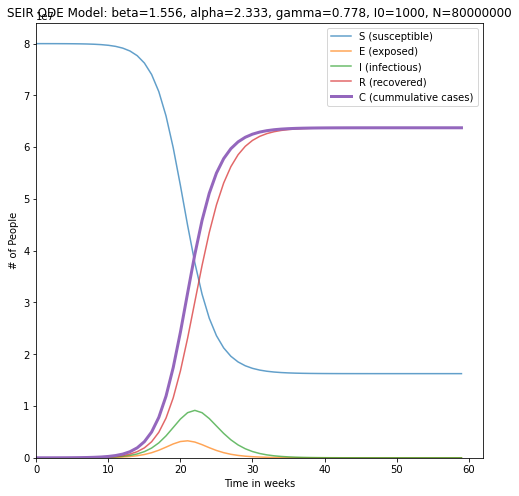

In [6]:
plot_seirc(params=[BETA, ALPHA, GAMMA, I_0], n=N, weeks=WEEKS)

## Latin Hypercube Sampling

In [7]:
#general implementation, independent from SEIR model
def latin_hypercube_uniform(dim, n_samples, low, high):
    if (len(low) != dim or len(high) != dim):
        raise Exception(f"{len(low)} low and {len(high)} high values given but should be {dim} values each")
    for l, h in zip(low, high):
        if (l >= h):
            raise Exception(f"Value for high ({h}) should be greater than value for low ({l})")

  
    #create array of shape(dim, n_samples) and transpose later.
    #This means all samples of one param are in one row vector which makes sampling easier
    arr = np.ndarray(shape=(dim, n_samples), dtype=float)
    rng = np.random.default_rng()
    
    for i in range(dim):
        subinterval_size = (high[i]-low[i])/n_samples
        
        arr[i] = np.linspace(low[i], high[i], n_samples, endpoint=False)
        #This is neccessary in multidimensional cases to create samples in the
        #entire space of the hypercube and not only on the diagonal
        np.random.shuffle(arr[i])
        
        for j in range(n_samples):
            arr[i][j] = rng.uniform(arr[i][j], arr[i][j] + subinterval_size)
    
    #Get back to the shape(n_samples, dim) so every line contains one param vector
    return arr.transpose()

### Verify LHS  (improved from Assignment2)

In [8]:
def test_samples(samples, low, high) -> bool:
    dimension = len(low)
    #Transpose back so every line contains all samples for an input var
    samples_t = samples.T
    
    for i in range(dimension):
        subinterval_size = (high[i] - low[i]) / len(samples_t[i])
        #undo the shuffling
        sorted_samples = np.sort(samples_t[i])
        for j in range(len(sorted_samples)):
            if not low[i] + j*subinterval_size <= sorted_samples[j] and sorted_samples[j] < low[i] + (j+1)*subinterval_size:
                print(f"Sample value {samples_t[i][j]} with i {i} and j {j} should be within boundaries {low[i]+j*subinterval_size} - {low[i] + (j+1)*subinterval_size}\n")
                return False

    return True

In [9]:
low = [1, 0.5, 0.5, 500]
high = [3, 3.5, 1, 2500]
samples = latin_hypercube_uniform(4, 1000, low, high)
if test_samples(samples, low, high):
    print("Samples are correct")
else:
    raise Exception("Given Samples do not match requirements for LHS-sampled values")

Samples are correct


Test the exceptions thrown by LHS function

In [10]:
low = [1, 2]
high = [3, 4, 5]

try:
    latin_hypercube_uniform(4, 1000, low, high)
except Exception as e:
    print(f"got following exception: {e}")
else:
    raise Exception("Expected an exception since low and high values dont match with dimension")

got following exception: 2 low and 3 high values given but should be 4 values each


In [11]:
low = [10]
high = [5]

try:
    latin_hypercube_uniform(1, 1000, low, high)
except Exception as e:
    print(f"got following exception: {e}")
else:
    raise Exception("Expected an exception since low value is higher than high value")

got following exception: Value for high (5) should be greater than value for low (10)


### Sobol Matrices

In [12]:
def create_sobol_matrices(A, B):
    if A.shape != B.shape:
        raise Exception(f"Shapes of Matrix A and B don't match. A has shape {A.shape} and B {B.shape}")
        
    #Transpose A and B to simplify the exchange of columns (rows after transpose)
    A_t = A.T
    B_t = B.T
    dim = len(A_t)
    n_samples = len(A)
    matrices = np.ndarray(shape=(dim, n_samples, dim), dtype=float)
    for i in range(dim):
        A_i = A_t.copy()
        A_i[i] = B_t[i]
        matrices[i] = A_i.T
    
    return matrices

#### Verify create_sobol_matrices

In [13]:
def test_create_sobol_matrices(A, B, M):
    
    dim = len(A.T)
    n_samples = len(A)
    valid = True

    #for each sobol-matrix
    for i in range(dim):
        # for each row
        for j in range(n_samples):
            #for each column
            for k in range(dim):
                #this is the column that should've been interchanged i.e. should be identical to B
                if(k==i):
                    if M[i][j][k] != B[j][k]:
                        print(f"Value in Column {k} and Row {j} of Sobol Matrix {i} is {M[i][j][k]} and does not match with Value in row {j} column {k} of Matrix B which is {B[j][k]}")
                        valid = False
                else: #Values should be identical to values of A
                    if M[i][j][k] != A[j][k]:
                        print(f"Value in Column {k} and Row {j} of Sobol Matrix {i} is {M[i][j][k]} and does not match with Value in row {j} column {k} of Matrix A which is {A[j][k]}")
                        valid = False
    return valid
        

In [14]:
#Manual verification - check if columns got replaced
a = np.matrix('1 2; 3 4; 5 6; 7 8')
b = np.matrix('0 9; 0 9; 0 9; 0 9')

print(a)
print(b)
print(create_sobol_matrices(a,b))

[[1 2]
 [3 4]
 [5 6]
 [7 8]]
[[0 9]
 [0 9]
 [0 9]
 [0 9]]
[[[0. 2.]
  [0. 4.]
  [0. 6.]
  [0. 8.]]

 [[1. 9.]
  [3. 9.]
  [5. 9.]
  [7. 9.]]]


In [15]:
low = [0, 0, 0, 0]
high = [1, 1, 1, 1]
a = latin_hypercube_uniform(4, 1000, low, high)
b = latin_hypercube_uniform(4, 1000, low, high)
if test_create_sobol_matrices(a, b, create_sobol_matrices(a,b)):
    print("Samples are correct")
else:
    raise Exception("Sobol Matrices do not meet the requirements")

Samples are correct


In [16]:
a = latin_hypercube_uniform(4, 1000, [0, 0, 0, 0], [1, 1, 1, 1])
b = latin_hypercube_uniform(5, 1000, [0, 0, 0, 0, 0], [1, 1, 1, 1, 1])
try:
    create_sobol_matrices(a,b)
except Exception as e:
    print(f"OK. As expected, got following exception: {e}")
else:
    raise Exception("Expected an exception since a and b have different shapes")

OK. As expected, got following exception: Shapes of Matrix A and B don't match. A has shape (1000, 4) and B (1000, 5)


### Compute Total Effect Sobol Indices

In [17]:
def compute_total_indices(f_A, f_AB):
    dim = len(f_AB)
    n_samples = len(f_A)
    
    sobol_total_indices = np.ndarray(shape=(dim), dtype=float)
    # We want to get the sample variance i.e. set ddof to 1
    var_y = np.var(f_A, ddof=1)
        
    # Calc the sobol total index via jansens estimator for all parameters
    for i in range(dim):
        
        variance_est_sum = 0.0
        for j in range(n_samples):
            variance_est_sum += (f_A[j] - f_AB[i][j])**2
        
        sobol_total_indices[i] = (variance_est_sum / (2*n_samples)) / var_y
        
    return sobol_total_indices

## Verify Sobol indices

In [18]:
def test_total_indices():

        
    A = latin_hypercube_uniform(4, 10000, [0,0,0,0], [1,1,1,1])
    B = latin_hypercube_uniform(4, 10000, [0,0,0,0], [1,1,1,1])
    
    sobol_matrices = create_sobol_matrices(A, B)
    
    f_A = np.array([x[0] + x[1] + x[2] + x[3] for x in A])
    f_AB = np.array([[x[0]+x[1] + x[2] + x[3] for x in mat]for mat in sobol_matrices])
    
    indices = compute_total_indices(f_A, f_AB)
    if abs(indices.sum() - 1) > 0.05:
        raise Exception(f"Sobol total indices for Y=x0+x1+x2+x3 should be nearly identical and add up to 1. Indices are {indices} and sum up to {indices.sum()}")  
    if abs(indices[0]-indices[1]) > 0.05 or abs(indices[1]-indices[2]) > 0.05 or abs(indices[2]-indices[3]) > 0.05:
        raise Exception(f"Sobol total indices for Y=x0+x1+x2+x3 should be nearly identical and add up to 1. Indices are {indices} and sum up to {indices.sum()}")  

    
    A = latin_hypercube_uniform(2, 10000, [0,0], [1,1])
    B = latin_hypercube_uniform(2, 10000, [0,0], [1,1])
    
    sobol_matrices = create_sobol_matrices(A, B)
    
    f_A = np.array([x[0] + x[1] for x in A])
    f_AB = np.array([[x[0]+x[1] for x in mat]for mat in sobol_matrices])
    
    indices = compute_total_indices(f_A, f_AB)
    if abs(indices[0]-indices[1]) > 0.05 or abs(indices.sum() -1 ) > 0.025:
        raise Exception(f"Sobol total indices for Y=x0+x1 should be nearly identical and add up to 1. Indices are {indices} and sum up to {indices.sum()}")
      
    
    f_A = np.array([x[0]*x[1] for x in A])
    f_AB = np.array([[x[0]*x[1] for x in mat]for mat in sobol_matrices])
    
    indices = compute_total_indices(f_A, f_AB)
    print(indices, indices.sum())
    if abs(indices[0]-indices[1]) > 0.05 or indices.sum() <= 1:
        raise Exception(f"Sobol total indices for Y=x0+x1 should be nearly identical and sum up to a value greater than 1. Indices are {indices} and sum up to {indices.sum()}")
      

    return True

In [19]:
if test_total_indices():
    print("Test Ok")
else:
    raise Exception("Test for Sobol indices failed")

[0.56629008 0.5670698 ] 1.1333598821972237
Test Ok


## Application of total-effect sobol indices to the SEIR model

The Hypercube for the model parameters is the same as in Assignment 2.\
Hypercube: H = [1,3] x [7/14, 7/2] x [7/14, 7/7] x [500, 2500]

In [20]:
def sample_and_solve(num_samples = 1000):
    
    A = latin_hypercube_uniform(DIMENSIONS, num_samples, PARAM_LOWS, PARAM_HIGHS)
    B = latin_hypercube_uniform(DIMENSIONS, num_samples, PARAM_LOWS, PARAM_HIGHS)
    
    #Save samples to file
    np.save('A.npy', A)
    sobol_matrices = create_sobol_matrices(A,B)
    np.save('AB.npy', sobol_matrices)

    #Integrate seir model for all param samples of A
    a_sol = np.array([integrate_seirc(A[i], N, WEEKS).y for i in range(num_samples)])
    np.save('A_solutions.npy', a_sol)
    
    #Integrate seir model for all param samples of all sobol matrices
    ab_sol = np.array([[integrate_seirc(sobol_matrices[i][j], N, WEEKS).y for j in range(num_samples)] for i in range(DIMENSIONS)])
    np.save('AB_solutions.npy', ab_sol)
    
    #For our usecase it would be enough to only store the QoI's. Storing the complete solution opens up the
    #possibility to analyse additional QoI's without doing all the recalculations


In [21]:
#Call this function manually to sample new parameters and therefore get new solutions to the SEIR model.
#Otherwise the samples stored in *.npy will be used

#sample_and_solve(SAMPLES)

In [22]:
#Check if param and solution file exists - if not create them by sampling params and calculate solution
try:
    f1 = open("A.npy")
    f2 = open("AB.npy")
    f3 = open("A_solutions.npy")
    f4 = open("AB_solutions.npy")
except FileNotFoundError:
    # Create solutions file by sampling parameters and solve seir model for them
    print("Sampling new params and calculate model results...")
    sample_and_solve(SAMPLES)
finally:
    f1.close()
    f2.close()
    f3.close()
    f4.close()

#### Calculate Sobol-total-effect indices for final cumulative cases

In [23]:
def cum_cases_sobol():
    solutions_A = np.load("A_solutions.npy")
    solutions_AB = np.load("AB_solutions.npy")
    
    #print(solutions_A)
    #print(solutions_AB)

    dim = len(solutions_AB)
    n_samples = len(solutions_A)
    
    f_A = np.ndarray(shape=(n_samples), dtype=float)
    for i in range(n_samples):
        f_A[i] = solutions_A[i][4][-1]
        
    f_AB = np.ndarray(shape=(dim, n_samples), dtype=float)
    for i in range(dim):
        for j in range(n_samples):
            f_AB[i][j] = solutions_AB[i][j][4][-1]

    sobol_indices = compute_total_indices(f_A, f_AB)
    return sobol_indices

sobol_indices are: 0.84 for beta, 0.03 for alpha, 
0.27 for gamma and 0.00 for I0 and sum up to 1.142


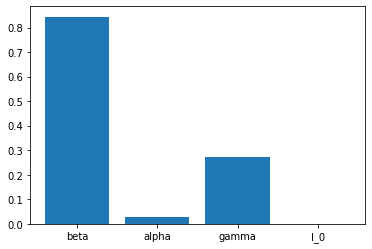

In [24]:
sobol_indices = cum_cases_sobol()
print(f'sobol_indices are: {sobol_indices[0]:.2f} for beta, {sobol_indices[1]:.2f} for alpha, \n{sobol_indices[2]:.2f} for gamma and {sobol_indices[3]:.2f} for I0 and sum up to {sobol_indices.sum():.3f}')
plt.bar(['beta', 'alpha', 'gamma', 'I_0'], sobol_indices)
plt.show()

#### Calculate Sobol-total-effect indices for week of peak infections

In [25]:
def peak_infections_sobol():
    solutions_A = np.load("A_solutions.npy")
    solutions_AB = np.load("AB_solutions.npy")

    dim = len(solutions_AB)
    n_samples = len(solutions_A)
    
    f_A = np.ndarray(shape=(n_samples), dtype=float)
    for i in range(n_samples):
        f_A[i] = np.argmax(solutions_A[i][2])
    #f_A = np.array([solutions[i][4][-1] for i in range(len(solutions))])

    f_AB = np.ndarray(shape=(dim, n_samples), dtype=float)
    for i in range(dim):
        for j in range(n_samples):
            f_AB[i][j] = np.argmax(solutions_AB[i][j][2])
    #f_AB = np.array([[solutions_AB[i][j][4][-1] for j in range(len(solutions_AB[i][j]))]for i in range(len(solutions_AB))])

    sobol_indices = compute_total_indices(f_A, f_AB)
    return sobol_indices

sobol_indices are: 0.84 for beta, 0.13 for alpha,
 0.13 for gamma and 0.01 for I0 and sum up to 1.103


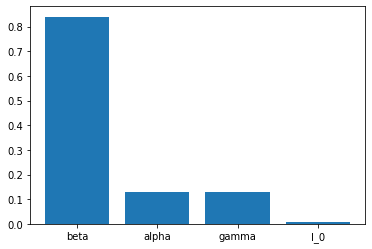

In [26]:
sobol_indices = peak_infections_sobol()
print(f'sobol_indices are: {sobol_indices[0]:.2f} for beta, {sobol_indices[1]:.2f} for alpha,\n {sobol_indices[2]:.2f} for gamma and {sobol_indices[3]:.2f} for I0 and sum up to {sobol_indices.sum():.3f}')
plt.bar(['beta', 'alpha', 'gamma', 'I_0'], sobol_indices)
plt.show()
